In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv("week4_data.csv")

In [4]:
small_df = data.sample(int(len(data)/400))
medium_df = data.sample(int(len(data)/40))

My beautiful code to generate the figures

In [30]:
class CrossValidator:

    def __init__(self, min_leaves, max_leaves, segments, data, X_variables, Y_variable):
        self.leaves = np.arange(min_leaves, max_leaves+1)
        self.data = data.sample(frac=1).reset_index(drop=True)
        self.X_variables = X_variables
        self.Y_variable = Y_variable
        self.segment_length = int(len(self.data)/segments)
        self.segments = []
        self.mses = {}
        indices = np.array_split(np.arange(len(self.data)), segments)
        for i in range(segments):
            test_idx = indices[i]
            train_idx = np.concatenate([indices[j] for j in range(segments) if j != i])
            test_data = self.data.iloc[test_idx]
            train_data = self.data.iloc[train_idx]
            self.segments.append((test_data, train_data))

        
        #for i in range(segments):
        #    split = i*self.segment_length
        #    test_data = self.data[split:split+self.segment_length]
        #    train_data = self.data.iloc[np.r_[0:split,split+self.segment_length:len(self.data)]]
        #    self.segments.append((test_data, train_data))
        self.results = pd.DataFrame({'True Y': [],
                                     'Pred Y': [],
                                     'Num Leaves': [],
                                     'Segment': [],
                                   'type': []})

    def test_model(self, segment, n_leaves):
        test_segment, train_segment = self.segments[segment]
        train_X = train_segment[self.X_variables].values
        train_Y = train_segment[self.Y_variable].values
        test_X = test_segment[self.X_variables].values
        test_Y = test_segment[self.Y_variable].values
        model = DecisionTreeRegressor(max_leaf_nodes=n_leaves)
        model = model.fit(train_X, train_Y)
        test_preds = model.predict(test_X)
        train_preds = model.predict(train_X)
        self.deviances = None
        self.Rs = None
        test_result = pd.DataFrame({'True Y': test_Y,
                               'Pred Y': test_preds,
                               'Num Leaves': n_leaves,
                               'Segment': [segment]*len(test_Y),
                               'type': ['test']*len(test_Y)}
                             )
        train_result = pd.DataFrame({'True Y': train_Y,
                               'Pred Y': train_preds,
                               'Num Leaves': n_leaves,
                               'Segment': [segment]*len(train_Y),
                               'type': ['train']*len(train_Y)})
        self.mses[n_leaves] = mean_squared_error(test_Y, test_preds)
        self.results = pd.concat([self.results, test_result, train_result])

    def generate_results(self):
        for i in range(len(self.segments)):
            for leaf in self.leaves:
                self.test_model(i, leaf)

    def calculate_Rs(self, data_type='train'):
        Rs = []
        data = self.results[self.results['type']==data_type]
        for leaf in self.leaves:
            results = data[data['Num Leaves']==leaf]
            slope, intercept, r_value, p_value, std_err = linregress(results['True Y'], results['Pred Y'])
            Rs.append(r_value)
        self.Rs = Rs
        
    def plot_r(self, data_type = 'train', ax=plt):
        if self.Rs is None:
            self.calculate_Rs(data_type)
        ax.scatter(self.leaves, self.Rs)
        ax.set_xlabel("Number of Terminal Nodes")
        ax.set_ylabel("$R^2$")

    def calculate_deviances(self, data_type='test'):
        deviances = []
        data = self.results[self.results['type']==data_type]
        for leaf in self.leaves:
            results = data[data['Num Leaves']==leaf]
            deviance = ((results['True Y']-results['Pred Y'])**2).sum()
            deviances.append(deviance)
        self.deviances = deviances
    
    def plot_deviance(self, data_type='test', ax=plt):
        if self.deviances is None:
            self.calculate_deviances(data_type)
        ax.scatter(self.leaves, self.deviances)
        ax.set_xlabel("Number of Terminal Nodes")
        ax.set_ylabel("Model Deviance")

    def optimal_nodes(self):
        return self.leaves[np.argmin(self.deviances)]

    def summarize_results(self):
        fig, axs = plt.subplots(1,2)
        self.plot_r(ax=axs[0])
        self.plot_deviance(ax=axs[1])
        fig.suptitle(f"Optimal Leaves: {self.optimal_nodes()}")
        fig.tight_layout()
    
        

In [33]:
small_validator = CrossValidator(2, 60, 10, small_df, ['fveg', 'northness', 'fSCA', 'TPI', 'elev'], 'lidar_SD')
small_validator.generate_results()

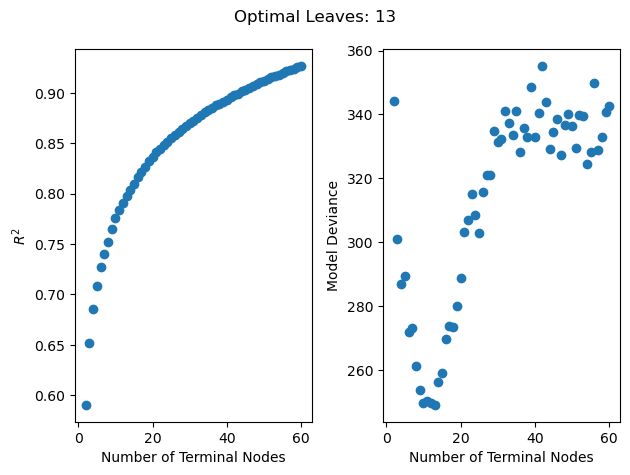

In [34]:
small_validator.summarize_results()

I feel like I'm going crazy.  I didn't change anything from last week but now I get a sensible result.  Goodness.  But 13 leaves seems reasonable.  Lets try with 10 times more data.

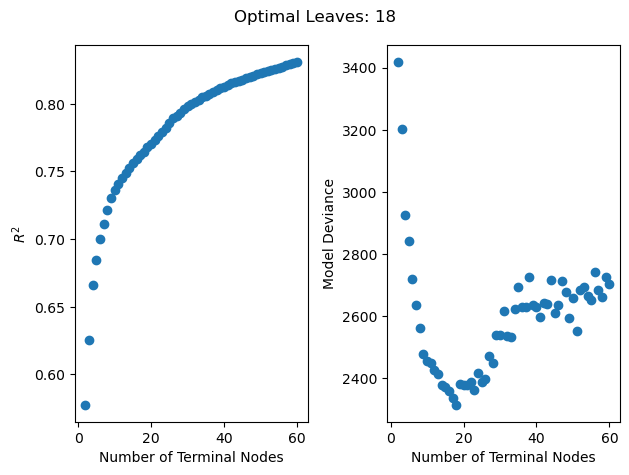

In [36]:
medium_validator = CrossValidator(2, 60, 10, medium_df, ['fveg', 'northness', 'fSCA', 'TPI', 'elev'], 'lidar_SD')
medium_validator.generate_results()
medium_validator.summarize_results()

It should be noted that different subsets of the data give different numbers of optimal leaves.